In [ ]:
import sys
import os
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import nltk
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
import math
from model import EncoderCNN, DecoderRNN
from data_loader import get_loader
from data_loader_val import get_loader as val_get_loader
from tqdm.notebook import tqdm
import torch.nn as nn
import json
from nlp_utils import clean_sentence, bleu_score
import matplotlib.pyplot as plt
from model import EncoderCNN, DecoderRNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive

mountPath = '/content/drive/'
drive.flush_and_unmount()
drive.mount(mountPath, force_remount=True)
projectPath = mountPath + 'MyDrive/image_captioning'
sys.path.append(projectPath)

Mounted at /content/drive/


Скачиваем val images 

In [ ]:
!wget -P /content/ http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip -d /content/

--2023-05-21 06:40:29--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.106.91, 54.231.201.233, 52.216.114.59, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.106.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘/content/val2014.zip.1’

val2014.zip.1       100%[===================>]   6.19G  47.6MB/s    in 2m 14s  

2023-05-21 06:42:43 (47.4 MB/s) - ‘/content/val2014.zip.1’ saved [6645013297/6645013297]

Archive:  /content/val2014.zip
replace /content/val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Скачиваем train images

In [ ]:
!wget -P /content/ http://images.cocodataset.org/zips/train2014.zip
!unzip /content/train2014.zip -d /content/

--2023-05-21 06:45:50--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.48.212, 52.217.254.41, 52.217.227.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.48.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘/content/train2014.zip.1’

train2014.zip.1       1%[                    ] 232.92M  41.2MB/s    eta 5m 20s ^C
Archive:  /content/train2014.zip
replace /content/train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Скачиваем annotations

In [ ]:
!wget -P /content/ http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip -d /content/

--2023-05-21 06:45:59--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.229.113, 52.216.80.208, 52.217.13.36, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.229.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘/content/annotations_trainval2014.zip.1’

     annotations_tr  15%[==>                 ]  36.47M  30.0MB/s               ^C
Archive:  /content/annotations_trainval2014.zip
replace /content/annotations/instances_train2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Скачиваем train images

In [ ]:
!wget -P /content/ http://images.cocodataset.org/zips/test2014.zip
!unzip /content/test2014.zip.1 -d /content/

--2023-05-21 08:31:39--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.196.33, 52.217.113.169, 52.216.166.43, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.196.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: ‘/content/test2014.zip.1’

test2014.zip.1      100%[===================>]   6.20G  47.2MB/s    in 2m 17s  

2023-05-21 08:33:55 (46.5 MB/s) - ‘/content/test2014.zip.1’ saved [6660437059/6660437059]

Archive:  /content/test2014.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/test2014.zip or
        /content/test2014.zip.zip, and cannot find /content/t

In [ ]:
batch_size = 128
vocab_threshold = 5
vocab_from_file = False
embed_size = 256
hidden_size = 512
num_epochs = 3
save_every = 1
print_every = 20
log_file = "training_log.txt"
cocoapi_dir = r"/content"

transform_train = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

In [ ]:
data_loader = get_loader(
    transform=transform_train,
    mode="train",
    batch_size=batch_size,
    vocab_threshold=vocab_threshold,
    vocab_from_file=vocab_from_file,
    cocoapi_loc=cocoapi_dir,
)

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [00:39<00:00, 10478.28it/s]


In [ ]:
vocab_size = len(data_loader.dataset.vocab)
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

criterion = (
    nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()
)

params = list(decoder.parameters()) + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

total_step = math.ceil(len(data_loader.dataset) / data_loader.batch_sampler.batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(total_step)

3236


In [ ]:
f = open(log_file, "w")

for epoch in range(1, num_epochs + 1):
    for i_step in range(1, total_step + 1):
        indices = data_loader.dataset.get_train_indices()
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        images, captions = next(iter(data_loader))
        images = images.to(device)
        captions = captions.to(device)

        decoder.zero_grad()
        encoder.zero_grad()

        features = encoder(images)
        outputs = decoder(features, captions)
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        loss.backward()
        optimizer.step()
        
        stats = (
            f"Epoch [{epoch}/{num_epochs}], Step [{i_step}/{total_step}], "
            f"Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):.4f}"
        )
        f.write(stats + "\n")
        f.flush()

        if i_step % print_every == 0:
            print("\r" + stats)

    if epoch % save_every == 0:
        torch.save(
            decoder.state_dict(), os.path.join("decoder-%d.pkl" % epoch)
        )
        torch.save(
            encoder.state_dict(), os.path.join("encoder-%d.pkl" % epoch)
        )
f.close()

In [ ]:
torch.save(decoder.state_dict(), os.path.join('decoder-final.pkl'))
torch.save(encoder.state_dict(), os.path.join('encoder-final.pkl'))

EVAl

In [ ]:
valPath = '/content'

In [ ]:
transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

val_data_loader = val_get_loader(
    transform=transform_test, mode="valid", cocoapi_loc=valPath
)

encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load(os.path.join(encoder_file)))
decoder.load_state_dict(torch.load(os.path.join(decoder_file)))

encoder.eval()
decoder.eval()

...
/content/annotations/captions_val2014.json
Vocabulary successfully loaded from vocab.pkl file!
/content/annotations/captions_val2014.json


DecoderRNN(
  (embed): Embedding(8852, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8852, bias=True)
)

In [ ]:
pred_result = defaultdict(list)
for img_id, img in tqdm(val_data_loader):
    img = img.to(device)
    with torch.no_grad():
        features = encoder(img).unsqueeze(1)
        output = decoder.sample(features)
    sentence = clean_sentence(output, val_data_loader.dataset.vocab.idx2word)
    pred_result[img_id.item()].append(sentence)

  0%|          | 0/40504 [00:00<?, ?it/s]

In [ ]:
with open(
    os.path.join(cocoapi_dir, "annotations/captions_val2014.json"), "r"
) as f:
    caption = json.load(f)

valid_annot = caption["annotations"]
valid_result = defaultdict(list)
for i in valid_annot:
    valid_result[i["image_id"]].append(i["caption"].lower())

In [ ]:
list(valid_result.values())[:3]

[['a bicycle replica with a clock as the front wheel.',
  'the bike has a clock as a tire.',
  'a black metal bicycle with a clock inside the front wheel.',
  'a bicycle figurine in which the front wheel is replaced with a clock\n',
  'a clock with the appearance of the wheel of a bicycle '],
 ['a black honda motorcycle parked in front of a garage.',
  'a honda motorcycle parked in a grass driveway',
  'a black honda motorcycle with a dark burgundy seat.',
  'ma motorcycle parked on the gravel in front of a garage',
  'a motorcycle with its brake extended standing outside'],
 ['a room with blue walls and a white sink and door.',
  'blue and white color scheme in a small bathroom.',
  'this is a blue and white bathroom with a wall sink and a lifesaver on the wall.',
  'a blue boat themed bathroom with a life preserver on the wall',
  'a bathroom with walls that are painted baby blue.']]

In [ ]:
list(pred_result.values())[:3]

[[' a man riding skis down a snow covered slope.'],
 [' a man riding a snowboard down a snow covered slope.'],
 [' a man riding a skateboard down a street.']]

In [ ]:
bleu_score(true_sentences=valid_result, predicted_sentences=pred_result)

0.2077467541693657

In [ ]:

cocoapi_dir = r"/content"

transform_test = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ]
)

data_loader = get_loader(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)

torch.Size([1, 318, 640, 3]) torch.Size([1, 3, 224, 224]) torch.Size([318, 640, 3])


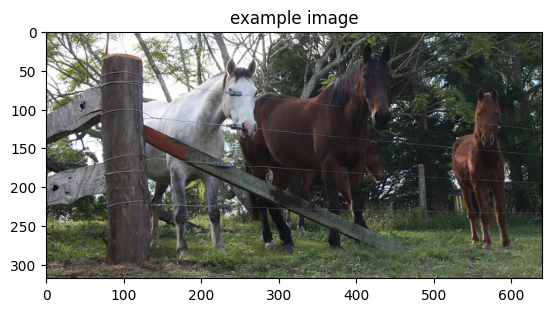

In [ ]:
orig_image, image = next(iter(data_loader))
print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()

In [ ]:
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

encoder.eval()
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join("/content", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("/content", decoder_file)))

encoder.to(device)
decoder.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DecoderRNN(
  (embed): Embedding(8852, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=8852, bias=True)
)

In [ ]:
image = image.to(device)
features = encoder(image).unsqueeze(1)

print(features.shape)
output = decoder.sample(features)
print("example output:", output)

torch.Size([1, 1, 256])
example output: [0, 3, 84, 6, 20, 134, 130, 135, 77, 3, 204, 18, 1]


In [ ]:
sentence = clean_sentence(output, data_loader.dataset.vocab.idx2word)

example sentence:  a brown and white horse is grazing in a field.


In [ ]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"/content/samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

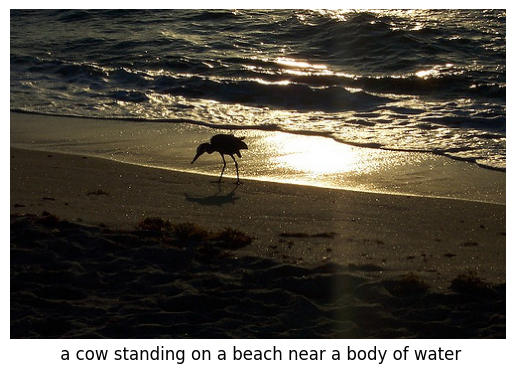

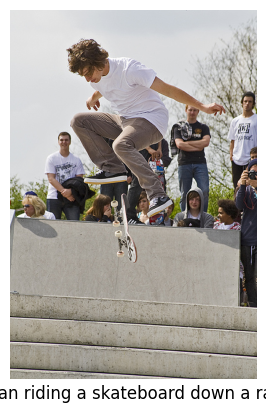

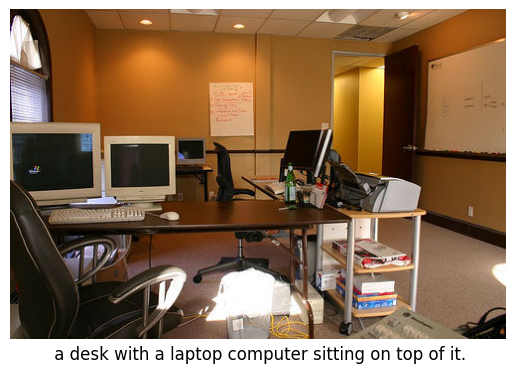

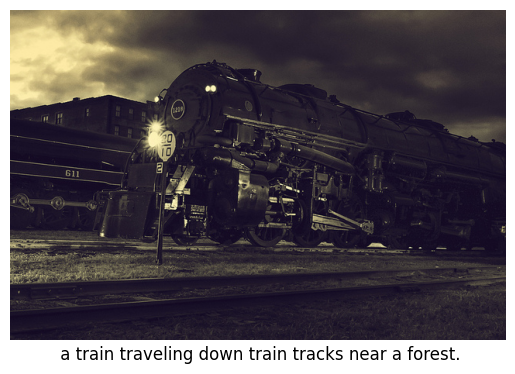

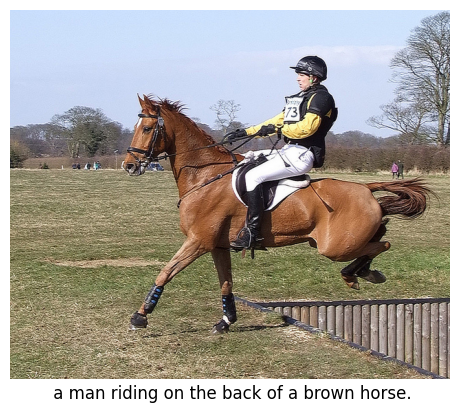

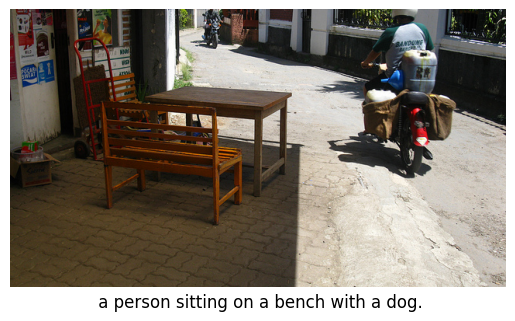

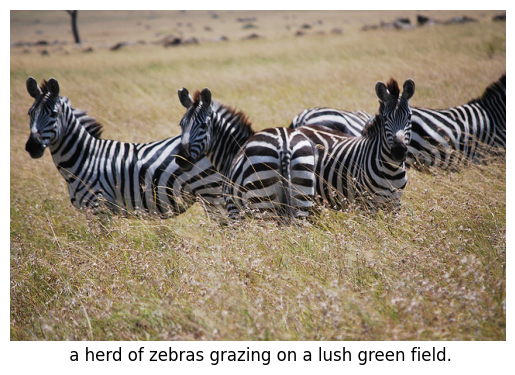

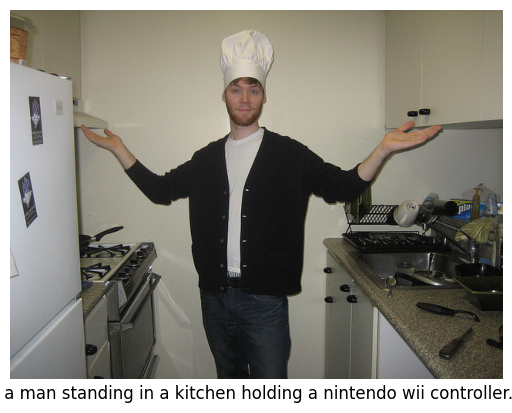

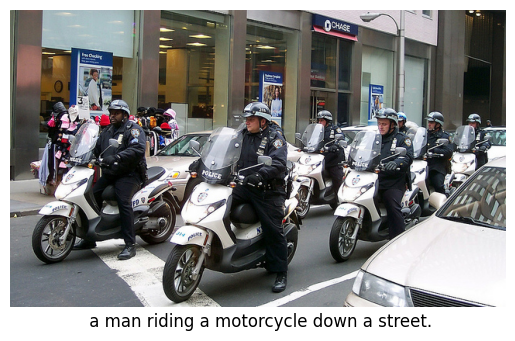

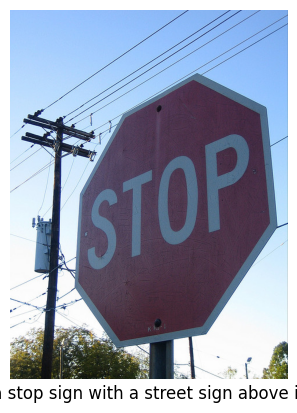

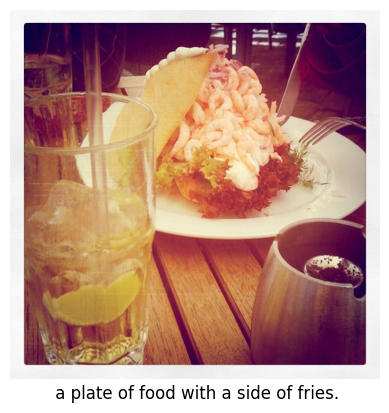

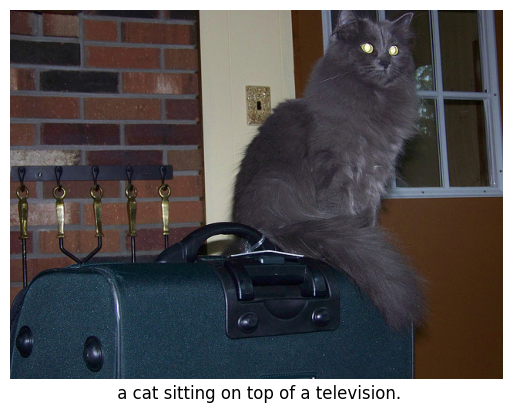

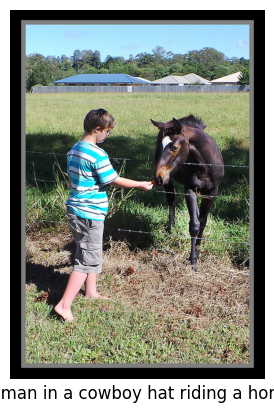

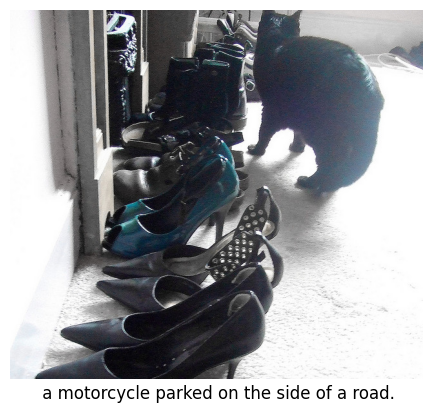

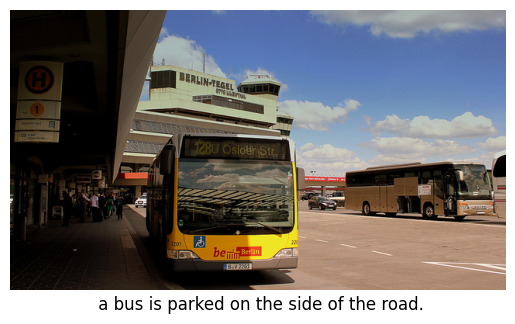

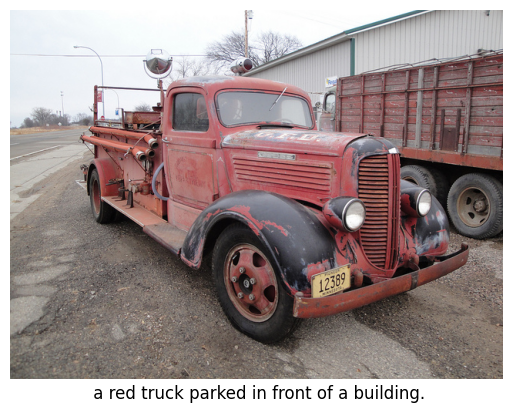

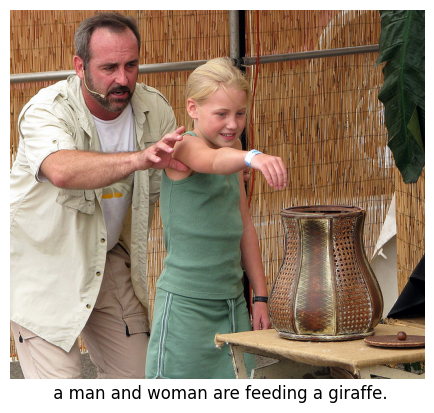

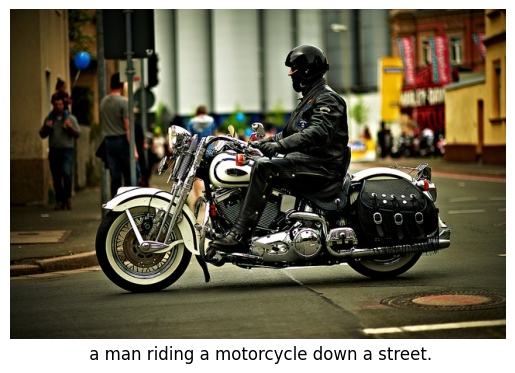

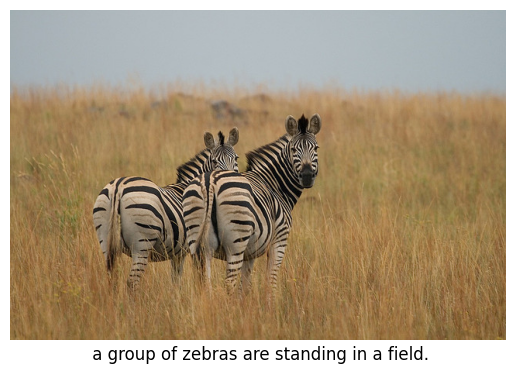

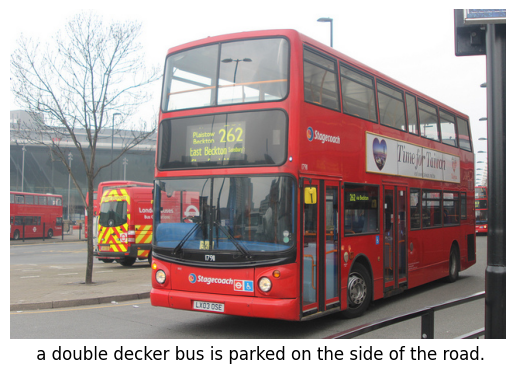

In [ ]:
for i in range(20):
    get_prediction(data_loader.dataset.vocab.idx2word, i=i)